In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib  as mpl
from tqdm import tqdm
import pickle
import lzma
import time
import os

import numpy as np

from DimensionReduction import Grassmann, DiffusionMaps
from GDMaps_PCE_GSA import *


# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [67]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(combinations(list(coord), 2))
    comb2 = list(combinations([i for i in range(coord.shape[0])], 2))

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()
        
        
def plot_dm_parsim_coord_multi_level(coords, gs):
    
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    titles = ["Micro-Level Diffusion Coordinates",
              "Meso-Level Diffusion Coordinates",
              "Global-Level Diffusion Coordinates"]
    
    for k, coord in enumerate(coords):
        comb1 = list(combinations(list(coord), 2))
        comb2 = list(combinations([i for i in range(coord.shape[0])], 2))
        
        g = gs[k]

        for i in range(len(comb1)):
            axs[k][i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            axs[k][i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            axs[k][i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            axs[k][i].grid('True')
            axs[k][i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))  
        
        axs[k][1].set_title(titles[k], fontsize=20, y=1.2)
    
    fig.tight_layout()
    plt.savefig("diffusion_coordinates.pdf", bbox_inches="tight")
    plt.show()


def run_GDMaps(p, 
               data, 
               num_runs=10, 
               n_keep=3, 
               parsim=True):
    
    evals_diff_runs  = []
    evecs_diff_runs  = []
    coord_diff_runs = []
    g_diff_runs = []
    residuals_diff_runs = []
    index_diff_runs = []
    
    for i in range(num_runs):
        print('Run: ', i)
        data_all = data[i]

        # Perform GDMAps
        start_time = time.time()
        
        if parsim:
            g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data_all, 
                                                                     n_evecs=20,
                                                                     n_keep=n_keep,
                                                                     parsim=parsim,
                                                                     p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
            residuals_diff_runs.append(residuals)
            index_diff_runs.append(index)
            
        else:
            g, coord, Grass, evals, evecs = GDMaps(data=data_all, 
                                                   n_evecs=20,
                                                   n_keep=n_keep,
                                                   parsim=parsim,
                                                   p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
        
        print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    return (evals_diff_runs, evecs_diff_runs, coord_diff_runs, g_diff_runs,
            residuals_diff_runs, index_diff_runs)

# Playground

### Micro

In [64]:
DATA = np.zeros((10, 8192, 250, 250), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir("./concat_W_arrays_cpt/"))):
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    # drop last time step
    data = data[:,:,:50].reshape(8192, 250, 250)
    DATA[i] = data

10it [03:02, 18.25s/it]


In [65]:
ranks = []
num_runs = 10

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

100%|███████████████████████████████████████████| 10/10 [14:37<00:00, 87.71s/it]

Ranks: 
 [[  62    1]
 [  63    2]
 [  64    5]
 [  65    3]
 [  66   12]
 [  67    6]
 [  68   18]
 [  69   19]
 [  70   47]
 [  71   54]
 [  72   73]
 [  73   68]
 [  74  106]
 [  75  164]
 [  76  236]
 [  77  223]
 [  78  295]
 [  79  312]
 [  80  499]
 [  81  526]
 [  82  531]
 [  83  506]
 [  84  568]
 [  85  849]
 [  86  686]
 [  87  608]
 [  88  659]
 [  89  720]
 [  90 1030]
 [  91  688]
 [  92  592]
 [  93  664]
 [  94  825]
 [  95  915]
 [  96  601]
 [  97  594]
 [  98  644]
 [  99  844]
 [ 100 1050]
 [ 101  822]
 [ 102  738]
 [ 103  793]
 [ 104  889]
 [ 105 1067]
 [ 106  737]
 [ 107  740]
 [ 108  735]
 [ 109  798]
 [ 110  882]
 [ 111  778]
 [ 112  726]
 [ 113  801]
 [ 114  785]
 [ 115  745]
 [ 116  627]
 [ 117  658]
 [ 118  764]
 [ 119  720]
 [ 120  699]
 [ 121  641]
 [ 122  690]
 [ 123  615]
 [ 124  594]
 [ 125  627]
 [ 126  647]
 [ 127  618]
 [ 128  543]
 [ 129  576]
 [ 130  584]
 [ 131  556]
 [ 132  536]
 [ 133  540]
 [ 134  540]
 [ 135  560]
 [ 136  509]
 [ 137  465]
 [ 

### Meso

In [4]:
with open("augmented_communities.pickle", "rb") as f:
    communities = pickle.load(f)
community_keys = sorted(list(communities.keys()))[:-1]

rand_comm_duplicates = list(np.random.choice(community_keys, size=8, replace=False))
community_keys += rand_comm_duplicates

In [5]:
DATA = np.zeros((10, 8192, 110, 110), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir("./concat_W_arrays_cpt/"))):
    
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    
    # drop some time steps
    data = data[:,:,:44]
    
    community_averages = np.zeros((8192, 275, 44), dtype=np.float16)
    for p_idx, param_item in enumerate(data):
        for k_idx, key in enumerate(community_keys):
            comm_avg = np.mean(param_item[communities[key]], axis=0)
            community_averages[p_idx][k_idx] = comm_avg

    DATA[i] = community_averages.reshape(8192, 110, 110)

10it [05:46, 34.64s/it]


In [6]:
ranks = []

num_runs = 10

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.87s/it]

Ranks: 
 [[   53     5]
 [   54    45]
 [   55    55]
 [   56    51]
 [   57    79]
 [   58    81]
 [   59    81]
 [   60   120]
 [   61   190]
 [   62   230]
 [   63   269]
 [   64   299]
 [   65   397]
 [   66   411]
 [   67   555]
 [   68   592]
 [   69   610]
 [   70   693]
 [   71   642]
 [   72   703]
 [   73   570]
 [   74   571]
 [   75   584]
 [   76   608]
 [   77   670]
 [   78   724]
 [   79   852]
 [   80   825]
 [   81   811]
 [   82   948]
 [   83   999]
 [   84   998]
 [   85   976]
 [   86   899]
 [   87  1030]
 [   88  1103]
 [   89  1141]
 [   90  1241]
 [   91  1283]
 [   92  1426]
 [   93  1390]
 [   94  1468]
 [   95  1989]
 [   96  1891]
 [   97  2433]
 [   98  2164]
 [   99  2526]
 [  100  3737]
 [  101  2421]
 [  102  1942]
 [  103  1876]
 [  104  1760]
 [  105  1861]
 [  106  2065]
 [  107  2245]
 [  108  3243]
 [  109 10014]
 [  110 12528]]


# Run micro level GDMaps

In [7]:
p_micro = 30
for i,f in enumerate(os.listdir("./concat_W_arrays_cpt/")):
    seed = int(f.split("_")[0])
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    data = data[:,:,:50].reshape(1, 8192, 250, 250)
    results = run_GDMaps(p=p_micro, data=data, num_runs=1)
    with open(f"GDMAPS_results/micro_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

Run:  0
Running with parsimonious representation
--- GDMaps - 3360.016257762909 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 3184.991469144821 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 3221.528689146042 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 3192.4955790042877 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 3207.8029849529266 seconds ---


# Run meso level GDMaps

In [3]:
with open("augmented_communities.pickle", "rb") as f:
    communities = pickle.load(f)
community_keys = sorted(list(communities.keys()))[:-1]

rand_comm_duplicates = list(np.random.choice(community_keys, size=8, replace=False))
community_keys += rand_comm_duplicates

In [4]:
p_meso = 70

for i,f in enumerate(os.listdir("./concat_W_arrays_cpt/")):
    
    seed = int(f.split("_")[0])
    if seed in [8,0,7]:
        continue
        
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    data = data[:,:,:44]
    
    community_averages = np.zeros((8192, 275, 44), dtype=np.float16)
    for p_idx, param_item in enumerate(data):
        for k_idx, key in enumerate(community_keys):
            comm_avg = np.mean(param_item[communities[key]], axis=0)
            community_averages[p_idx][k_idx] = comm_avg
    
    data = community_averages.reshape(1, 8192, 110, 110)
    
    results = run_GDMaps(p=p_meso, data=data, num_runs=1)
    with open(f"GDMAPS_results/meso_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

Run:  0
Running with parsimonious representation
--- GDMaps - 5193.033439874649 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 5414.4077870845795 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 6621.766417264938 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 5483.2568147182465 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 5792.912516832352 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 5203.64333486557 seconds ---
Run:  0
Running with parsimonious representation
--- GDMaps - 6713.055519104004 seconds ---


# Run global level GDMaps

In [ ]:
p_global = 4

for i,f in enumerate(os.listdir("./concat_W_arrays_cpt/")):
    seed = int(f.split("_")[0])
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    data = np.mean(data, axis=1)[:,:49].reshape(1, 8192, 7, 7)
    results = run_GDMaps(p=p_global, data=data, num_runs=1)
    with open(f"GDMAPS_results/global_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

# Plot results

In [69]:
# fig, axs = plt.subplots(3,3)

seed = 0

coords = []
gs = []


for i,path in enumerate([f"micro_{seed}.pickle", f"meso_{seed}.pickle", f"global_{seed}.pickle"]):
    
    with open("GDMAPS_results/" + path, "rb") as f:
        evals, evecs_diff_runs, coord, g_diff_runs, \
            residuals_diff_runs, index_diff_runs = pickle.load(f)
    
    coords.append(coord[0])
    gs.append(g_diff_runs[0])

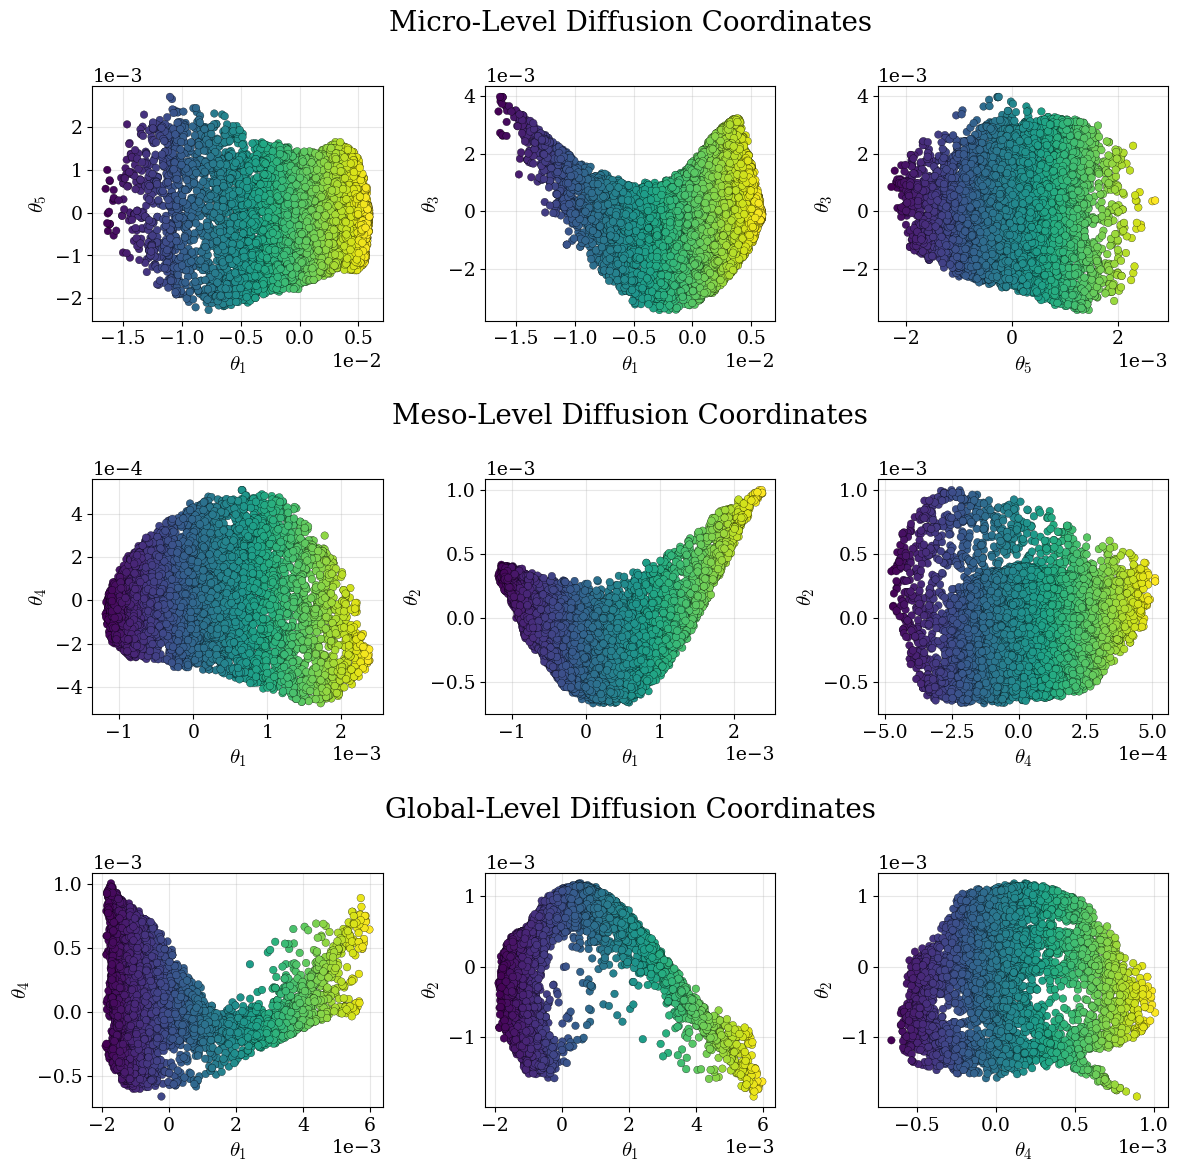

In [70]:
plot_dm_parsim_coord_multi_level(coords, gs)

In [16]:
# evals = evals[0]
# plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
# plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
# plt.tight_layout()
# plt.show()

In [34]:
# plot_dm_parsim_coord(coord[0], g_diff_runs[0])